In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from binconvfm.models.lstm import LSTMForecaster
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [13]:
class Seq2SeqDataset(Dataset):
    def __init__(self, seq, input_len=24, output_len=5):
        self.input_len = input_len
        self.output_len = output_len
        self.seq = torch.tensor(seq, dtype=torch.float32)
        self.seq = self.seq.unsqueeze(-1)
        self.length = len(seq) - input_len - output_len + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        input_seq = self.seq[idx : idx + self.input_len]
        target_seq = self.seq[idx + self.input_len : idx + self.input_len + self.output_len]
        return input_seq, target_seq

In [14]:
x_space = np.linspace(0, 100, 1000)
seq = np.sin(x_space) + np.random.randn(1000)*0.1

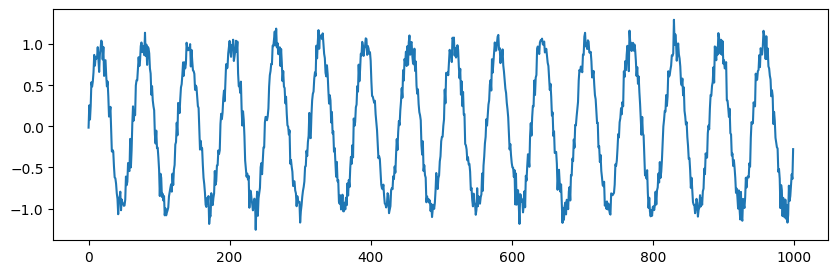

In [15]:
plt.figure(figsize=(10, 3))
plt.plot(seq)
plt.show()

In [16]:
input_len = 100
output_len = 50

ds = Seq2SeqDataset(seq, input_len, output_len)
train_dataloader = DataLoader(ds, batch_size=32, shuffle=True)
val_dataloader = DataLoader(ds, batch_size=32, shuffle=False)
test_dataloader = DataLoader(ds, batch_size=32, shuffle=False)
pred_dataloader = DataLoader(ds, batch_size=32, shuffle=False)

In [17]:
model = LSTMForecaster(horizon=output_len, hidden_dim=64, num_epochs=5)
model.fit(train_dataloader, val_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LSTM | 17.2 K | train
---------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                              | 0/? [00:00<?…

/Users/vitaliypozdnyakov/miniconda3/envs/binconv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                     | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

Validation: |                                                                                   | 0/? [00:00<?…

`Trainer.fit` stopped: `max_epochs=5` reached.


In [18]:
model.evaluate(test_dataloader)

/Users/vitaliypozdnyakov/miniconda3/envs/binconv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |                                                                                      | 0/? [00:00<?…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          crps              0.09585932642221451
          mase              1.8353650569915771
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mase': 1.8353650569915771, 'crps': 0.09585932642221451}]

In [19]:
pred = model.predict(pred_dataloader)
pred[0].shape

/Users/vitaliypozdnyakov/miniconda3/envs/binconv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |                                                                                   | 0/? [00:00<?…

torch.Size([32, 1000, 50, 1])

In [23]:
pred_seq

tensor([[0.6563],
        [0.7991],
        [0.8888]])

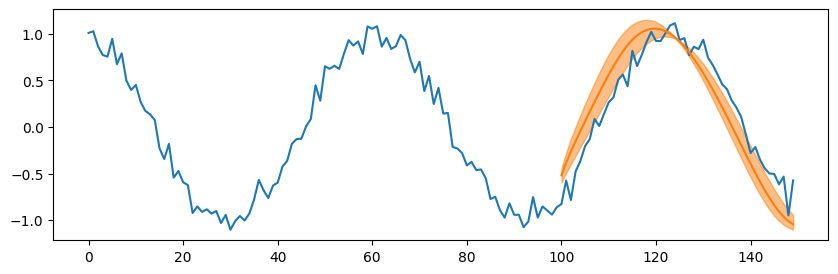

In [25]:
idx0 = torch.randint(len(pred), (1,)).item()
idx1 = torch.randint(len(pred[idx0]), (1,)).item()
input_seq, target_seq = list(pred_dataloader)[idx0]
input_seq, target_seq = input_seq[idx1, :, -1], target_seq[idx1, :, -1]
q = torch.tensor([0.01, 0.5, 0.99])
pred_seq = torch.quantile(pred[idx0][idx1, :, :, -1], q=q, dim=0)

plt.figure(figsize=(10, 3))
plt.plot(range(input_len+output_len), torch.concat([input_seq, target_seq]))
plt.plot(range(input_len, input_len+output_len), pred_seq[1])
plt.fill_between(range(input_len, input_len+output_len), pred_seq[0], pred_seq[2], alpha=0.5, color='tab:orange')
plt.show()